Test

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import pyvista as pv
import numpy as np
import openpyxl as py
import paho.mqtt.client as mqtt
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from dash import Dash, html, dcc
import plotly.express as px


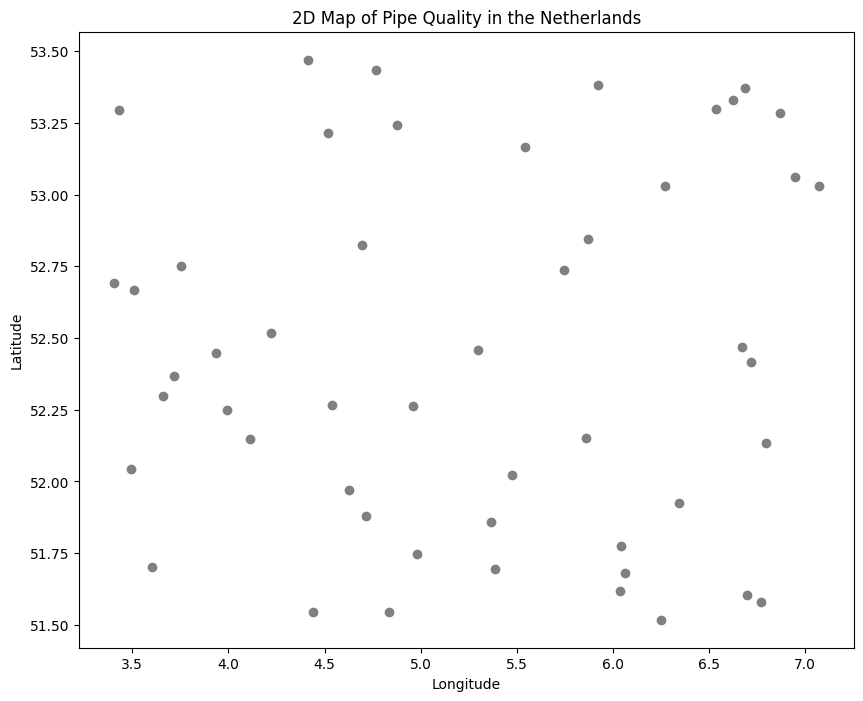

In [32]:
# Load dataset
file_path = 'Testdata.xlsx'  # Assuming this path holds the dataset
pipe_data = pd.read_excel(file_path)

# 2D Map of Pipe Locations
def draw_pipe_map():
    fig, ax = plt.subplots(figsize=(10, 8))
    quality_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}

    for i, row in pipe_data.iterrows():
        plt.scatter(row['Longitude'], row['Latitude'], color=quality_colors.get(row['QualityCheckStatus'], 'gray'), label=f"QualityCheckStatus {row['QualityCheckStatus']}")

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('2D Map of Pipe Quality in the Netherlands')
    plt.show()

draw_pipe_map()

/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning:

Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.



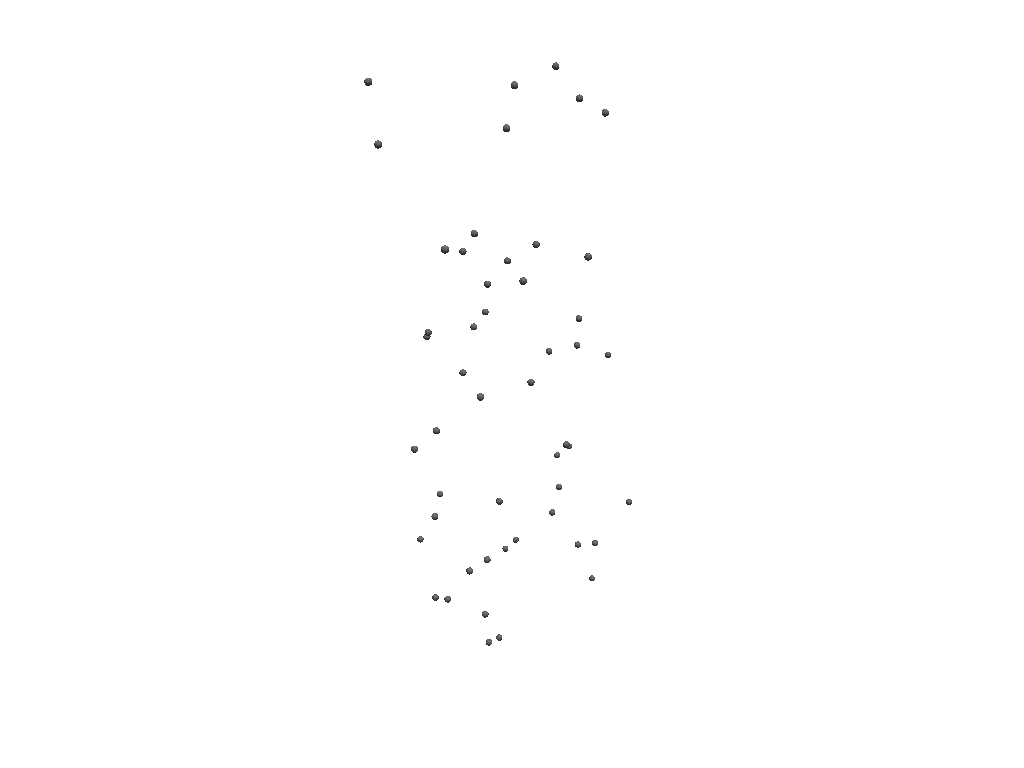

In [33]:
# Random z-coordinates to simulate depth or elevation
pipe_data['z'] = np.random.uniform(0, 10, size=len(pipe_data))

# 3D Model of Pipes
def draw_3d_pipes():
    plotter = pv.Plotter()
    quality_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}
    
    for i, row in pipe_data.iterrows():
        point = pv.Sphere(radius=0.05, center=(row['Longitude'], row['Latitude'], row['z']))
        plotter.add_mesh(point, color=quality_colors.get(row['QualityCheckStatus'], 'gray'))

    plotter.show()

draw_3d_pipes()

In [34]:

# Simulated message handler
def on_message(client, userdata, msg):
    data = json.loads(msg.payload.decode())
    print(f"Pipe ID: {data['pipe_id']}, Pressure: {data['pressure']}, Flow Rate: {data['flow_rate']}")

client = mqtt.Client()
client.on_message = on_message
client.connect("test.mosquitto.org", 1883, 60)
client.subscribe("test/topic")
client.loop_start()

/var/folders/c1/7hq1ct91269cpqzjpgl886cm0000gn/T/ipykernel_5509/4056789534.py:6: DeprecationWarning:

Callback API version 1 is deprecated, update to latest version



<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

Exception in thread paho-mqtt-client-:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/paho/mqtt/client.py", line 4523, in _thread_main
    self.loop_forever(retry_first_connection=True)
  File "/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/paho/mqtt/client.py", line 2297, in loop_forever
    rc = self._loop(timeout)
  File "/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/paho/mqtt

In [35]:


# Create hypothetical dataset for training
pipe_data['maintenance_required'] = np.random.randint(0, 2, size=len(pipe_data))
X = pipe_data[['SedimentLevel (%)', 'Diameter (mm)', 'Length (m)']]
y = pipe_data['maintenance_required']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)


In [36]:


app = Dash(__name__)

# Plotly map for Dash visualization
fig = px.scatter_mapbox(pipe_data, lat="Latitude", lon="Longitude", color="QualityCheckStatus",
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

app.layout = html.Div(children=[
    html.H1(children='Pipe Quality Digital Twin - Netherlands'),
    dcc.Graph(id='pipe-map', figure=fig)
])

if __name__ == '__main__':
    app.run_server(debug=True)
